In [30]:
import numpy as np
import json

with open('cranfield\cran_qrels.json', 'r') as f:
    data = json.load(f)

data_set = np.zeros((1400*225,3) , dtype=int)

idx = 0
count = 0

for i in range(1,1401):
    for j in range(1,226):
        data_set[idx][0] = i
        data_set[idx][1] = j
        if ({'query_num' : str(j), 'position' : 1 , 'id' : 
            str(i)}) in data : data_set[idx][2] = 1
        if ({'query_num' : str(j), 'position' : 2 , 'id' : 
            str(i)}) in data : data_set[idx][2] = 1
        if ({'query_num' : str(j), 'position' : 3 , 'id' : 
            str(i)}) in data : data_set[idx][2] = 1
        if ({'query_num' : str(j), 'position' : 4 , 'id' : 
            str(i)}) in data : data_set[idx][2] = 1
        idx+=1

In [31]:
np.savetxt('cranfield/dataset.csv', data_set, fmt="%s")

data_set = np.genfromtxt('cranfield/dataset.csv' , dtype=int)

print(len(data))
print(np.sum(data_set,axis=0))

1837
[220657500  35595000      1837]


In [102]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

doc_seq = np.genfromtxt('cranfield_sequences/doc_seq.csv', dtype=int)
query_seq = np.genfromtxt('cranfield_sequences/q_seq.csv', dtype=int)
y = data_set[:,2]
x_doc_seq = np.array([doc_seq[(data_set[i][0])-1] for i in range(len(data_set))])
x_query_seq = np.array([query_seq[(data_set[i][1])-1] for i in range(len(data_set))])

HIDDEN_SIZE = 128
VOCAB_SIZE = 9000
EMBEDDING_DIM = 64
DENSE_SIZE = 32

doc_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="doc_input")
query_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="query_input")

embedding_layer = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)

doc_embedding = embedding_layer(doc_input)
doc_dense_layer = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(doc_embedding)
doc_lstm_layer = tf.keras.layers.LSTM(HIDDEN_SIZE, return_state=True)(doc_dense_layer)
doc_encoder, doc_hidden_state, doc_cell_state = doc_lstm_layer

query_embedding = embedding_layer(query_input)
query_dense_layer = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(query_embedding)
query_lstm_layer = tf.keras.layers.LSTM(HIDDEN_SIZE, return_state=True)(query_dense_layer)
query_encoder, query_hidden_state, query_cell_state = query_lstm_layer

concatenated = tf.keras.layers.concatenate([doc_encoder, query_encoder])

dense_layer_1 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(concatenated)
dense_layer_2 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_1)

output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer_2)

model = tf.keras.models.Model(inputs=[doc_input, query_input], outputs=output_layer)

# Create new models to get the hidden states
doc_model = tf.keras.models.Model(inputs=doc_input, outputs=[doc_hidden_state, doc_cell_state])
query_model = tf.keras.models.Model(inputs=query_input, outputs=[query_hidden_state, query_cell_state])

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt, metrics=["mse"])

history = model.fit(
    {"doc_input": x_doc_seq, "query_input": x_query_seq},
    y,
    epochs=5,
    batch_size=32,
    validation_split=0.3
)

doc_model.save("results\doc_model")
query_model.save("results\query_model")


Epoch 1/5
6891/6891 [==============================] - 7231s 1s/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/5
6891/6891 [==============================] - 4675s 678ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 3/5
6891/6891 [==============================] - 5006s 726ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/5
6891/6891 [==============================] - 4694s 681ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/5
6891/6891 [==============================] - 4523s 656ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0046 - val_mse: 0.0046


INFO:tensorflow:Assets written to: results\doc_model\assets


INFO:tensorflow:Assets written to: results\doc_model\assets


INFO:tensorflow:Assets written to: results\query_model\assets


INFO:tensorflow:Assets written to: results\query_model\assets


In [38]:
doc_seq = np.genfromtxt('cranfield_sequences/doc_seq.csv', dtype=int)
query_seq = np.genfromtxt('cranfield_sequences/q_seq.csv', dtype=int)
y = data_set[:,2]
x_doc_seq = np.array([doc_seq[(data_set[i][0])-1] for i in range(len(data_set))])
x_query_seq = np.array([query_seq[(data_set[i][1])-1] for i in range(len(data_set))])

HIDDEN_SIZE = 64
VOCAB_SIZE = 9000
EMBEDDING_DIM = 64
DENSE_SIZE = 64

doc_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="doc_input")
query_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="query_input")

embedding_layer = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)

doc_embedding = embedding_layer(doc_input)
doc_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(doc_embedding)

query_embedding = embedding_layer(query_input)
query_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(query_embedding)

concatenated = tf.keras.layers.concatenate([doc_encoder, query_encoder])
dense_layer_1 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(concatenated)
dense_layer_2 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_1)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer_2)
model = tf.keras.models.Model(inputs=[doc_input, query_input], outputs=output_layer)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])

model.fit(
    {"doc_input": x_doc_seq, "query_input": x_query_seq},
    y,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
7875/7875 [==============================] - 1805s 229ms/step - loss: 0.0081 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 0.9963
Epoch 2/5
7875/7875 [==============================] - 1299s 165ms/step - loss: 0.0063 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 0.9963
Epoch 3/5
7875/7875 [==============================] - 1411s 179ms/step - loss: 0.0063 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 0.9963
Epoch 4/5
7875/7875 [==============================] - 1422s 181ms/step - loss: 0.0063 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 0.9963
Epoch 5/5
7875/7875 [==============================] - 1446s 184ms/step - loss: 0.0063 - accuracy: 0.9936 - val_loss: 0.0037 - val_accuracy: 0.9963


8/8 [==============================] - 1s 86ms/step
Epoch 1/20
368/368 [==============================] - 2s 3ms/step - loss: 1.1115 - accuracy: 0.2192 - val_loss: 1.0602 - val_accuracy: 0.1793
Epoch 2/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0891 - accuracy: 0.2185 - val_loss: 1.0379 - val_accuracy: 0.1793
Epoch 3/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0725 - accuracy: 0.2158 - val_loss: 1.0212 - val_accuracy: 0.1793
Epoch 4/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0582 - accuracy: 0.3799 - val_loss: 1.0063 - val_accuracy: 0.4538
Epoch 5/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0459 - accuracy: 0.3860 - val_loss: 0.9930 - val_accuracy: 0.4538
Epoch 6/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0344 - accuracy: 0.3860 - val_loss: 0.9807 - val_accuracy: 0.4538
Epoch 7/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0244 - accuracy: 0.3

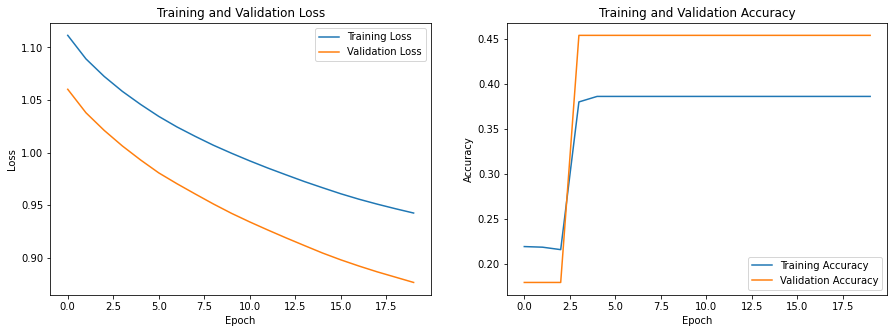

In [103]:
# my_model = tf.keras.models.load_model('results\my_model')

doc_seq = np.genfromtxt('cranfield_sequences/doc_seq.csv', dtype=int)
query_seq = np.genfromtxt('cranfield_sequences/q_seq.csv', dtype=int)

# Feed sequences and generate embeddings
# doc_model = tf.keras.models.Model(inputs=model.input[0], outputs=model.layers[3].output[1:])
# query_model = tf.keras.models.Model(inputs=model.input[1], outputs=model.layers[4].output[1:])

# use the new models to get the hidden states for a given input sequence
doc_hidden_state, doc_cell_state = doc_model.predict(doc_seq)
query_hidden_state, query_cell_state = query_model.predict(query_seq)

np.savetxt('cranfield_sequences\doc_seq_embedding_2.csv', doc_hidden_state, fmt = "%s")
np.savetxt('cranfield_sequences\q_seq_embedding_2.csv', query_hidden_state, fmt = "%s")